In [1161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neural_network import MLPClassifier

%matplotlib inline

# Gather data

In [1162]:
df = pd.read_csv('winemag-data-130k-v2.csv')

# Assess data

In [1163]:
df.shape

(129971, 14)

In [1164]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [1165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [1167]:
# Function to produce countplots for various features
def plot_values(df, feature, title=""):
    '''
    INPUT
    df - pandas dataframe 
    feature - one named feature that is part of this dataset
    title - Used as the title of the plot
    
    OUTPUT
    (none)
    
    '''    
    sb.set(rc={'figure.figsize':(16,9)})
    p = sb.countplot(x = feature, 
              data = df,
              order = df[feature].value_counts().index)
    p.set_title(title)
    for item in p.get_xticklabels():
        item.set_rotation(90)

In [1168]:
len(df.country.value_counts())

43

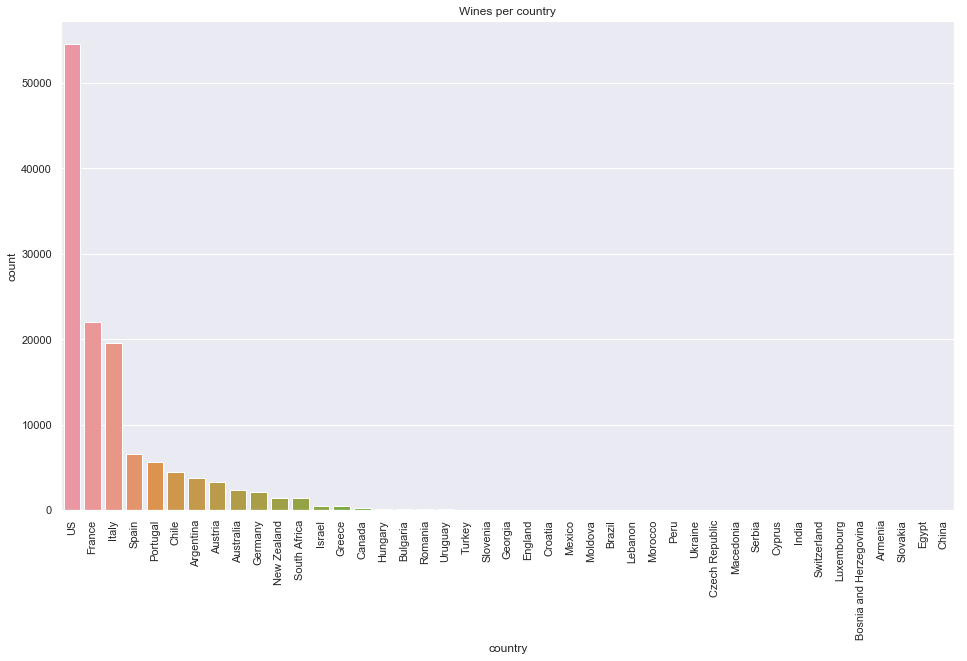

In [1169]:
plot_values(df, 'country', 'Wines per country')

In [1170]:
df.isnull().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

# Clean data

### Remove rows where the price is missing

In [1171]:
df.dropna(subset=['price'], inplace=True)

### Extract the year from the title and store it in a new column

In [1172]:
def get_year(title):
    '''
    INPUT
    title - a string containing the year as a four-digit string 
    
    OUTPUT
    year as an int, or NaN if the year could not be extracted from the title
    
    '''    
    # Some wines has a four-digit year as part of the name, typically much older than the production year we're after.
    # We'll use a "cutoff" value and ignore years older than this value
    cutoff = 1950
    thisyear = 2018
    ts = title.split(" ")
    for s in ts:
        if len(s) == 4:
            try:
                year = int(s)
                if ((year > cutoff) and (year <= thisyear)):
                    return year
            except:
                pass
    return np.nan

In [1173]:
df['year'] = df.title.apply(lambda x: get_year(x))

In [1174]:
df.year.isnull().sum()

4159

In [1175]:
# We'll simply drop rows where the year is missing
df.dropna(subset=['year'], inplace=True)

In [1176]:
df.shape

(116816, 15)

In [1177]:
df.isnull().sum()

Unnamed: 0                   0
country                     59
description                  0
designation              34486
points                       0
price                        0
province                    59
region_1                 19119
region_2                 67276
taster_name              23563
taster_twitter_handle    28379
title                        0
variety                      1
winery                       0
year                         0
dtype: int64

# Analyze data

## 1. Which country/region produces the best wine

We can look at this in two ways: 
1. Which countries and regions have the most wines among the top-rated ones?
2. What is the average rating of wines from the different countries and regions?

## Top-rated wines per country and province

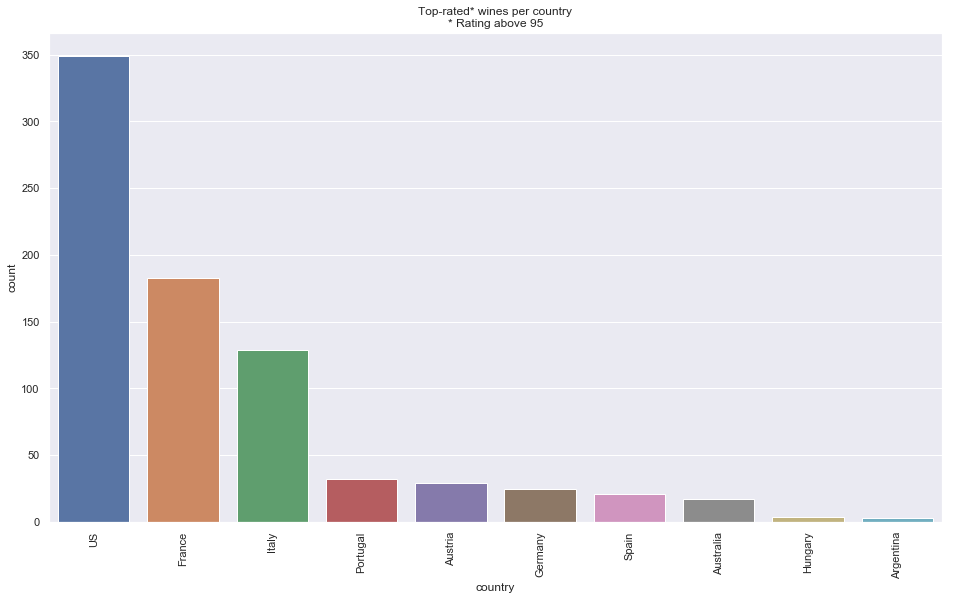

In [1178]:
wtop = df[df.points > 95]
plot_values(wtop, 'country', 'Top-rated* wines per country\n* Rating above 95')

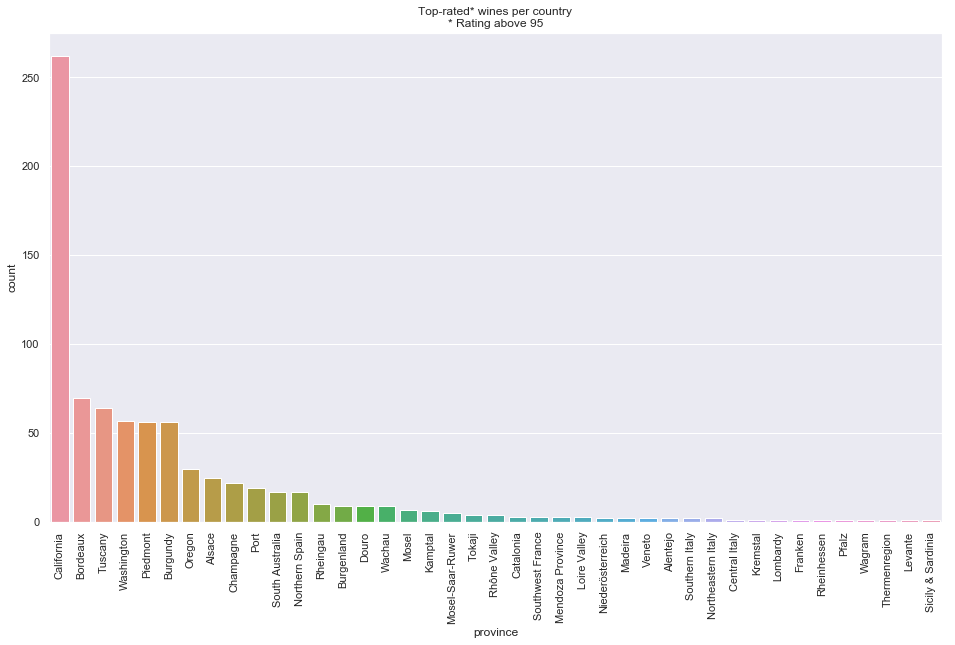

In [1179]:
wtop = df[df.points > 95]
plot_values(wtop, 'province', 'Top-rated* wines per country\n* Rating above 95')

## Average rating per country and region

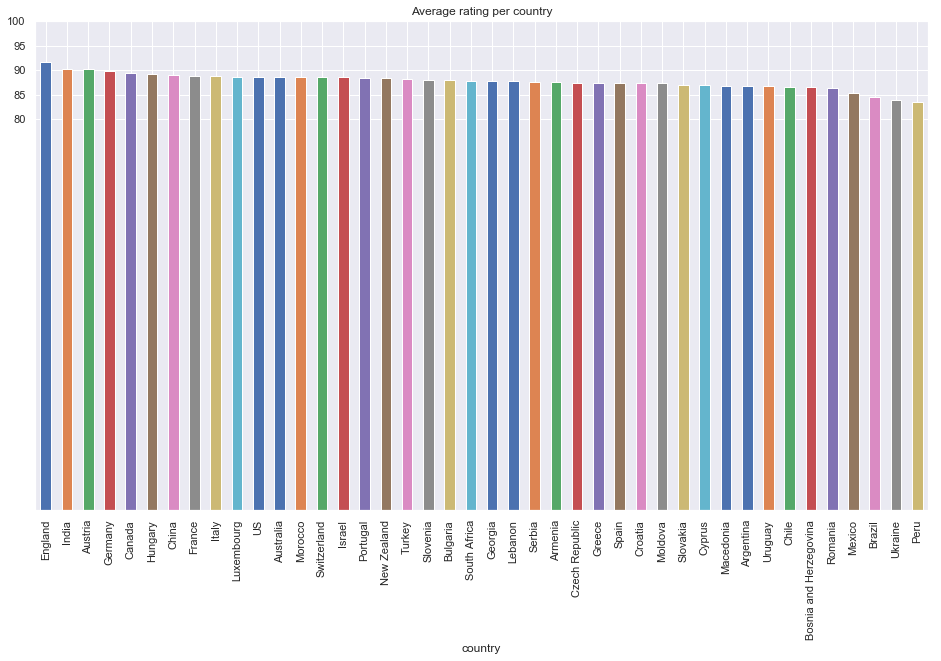

In [1180]:
yrange = np.arange(80,101,5)
wmean = df.groupby('country')['points'].mean()
wmean.sort_values(ascending=False, inplace=True)
p = wmean.plot(kind='bar', title='Average rating per country', yticks=yrange);

In [1181]:
df[df.country == 'England'].shape[0]

55

In [1182]:
df[df.country == 'India'].shape[0]

9

In [1183]:
df[df.country == 'Austria'].shape[0]

2766

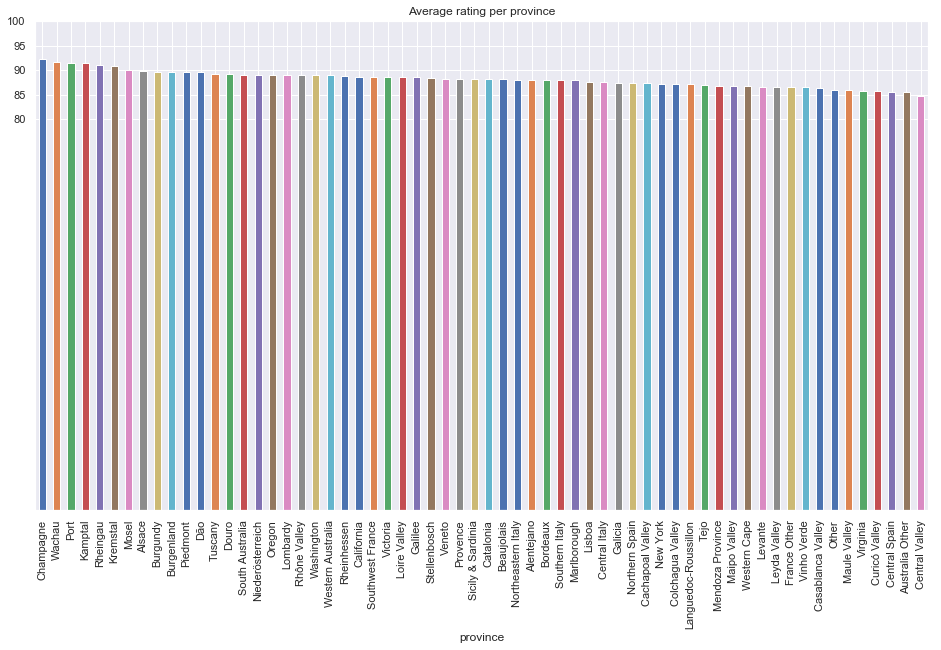

In [1184]:
provs = df.groupby('province').filter(lambda x: len(x) > 200)
yrange = np.arange(80,101,5)
wmean = provs.groupby('province')['points'].mean()
wmean.sort_values(ascending=False, inplace=True)
p = wmean.plot(kind='bar', title='Average rating per province', yticks=yrange);

## Let's also plot the average price per country of production

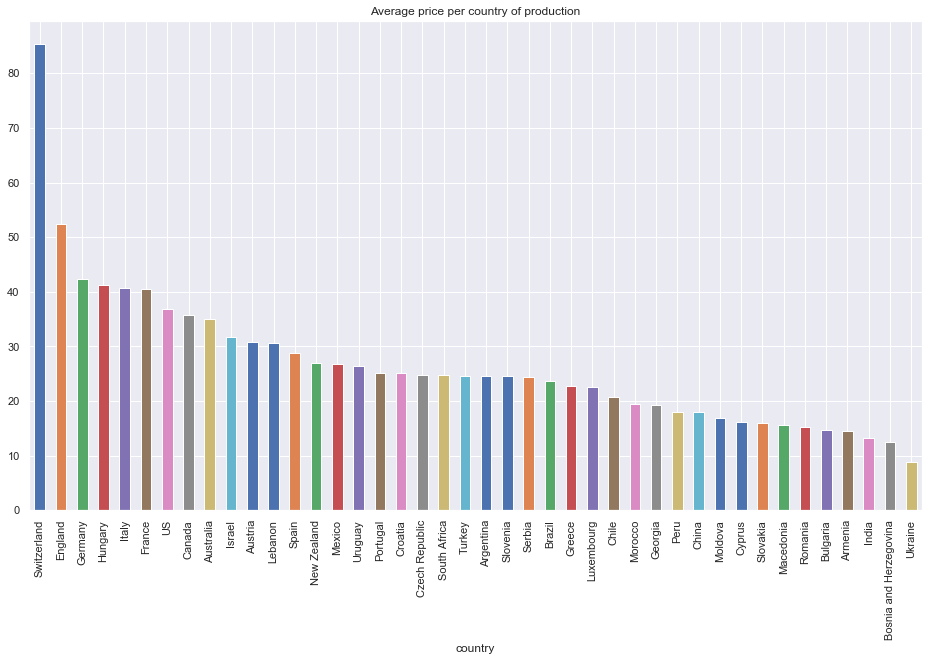

In [1185]:
wmean = df.groupby('country')['price'].mean()
wmean.sort_values(ascending=False, inplace=True)
wmean.plot(kind='bar', title='Average price per country of production');

## 2. Relationship between points and price

In [1186]:
pp = ['points', 'price']
corr_df=df[pp] 
cor = corr_df.corr(method='pearson')
print(cor)

          points     price
points  1.000000  0.415917
price   0.415917  1.000000


C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


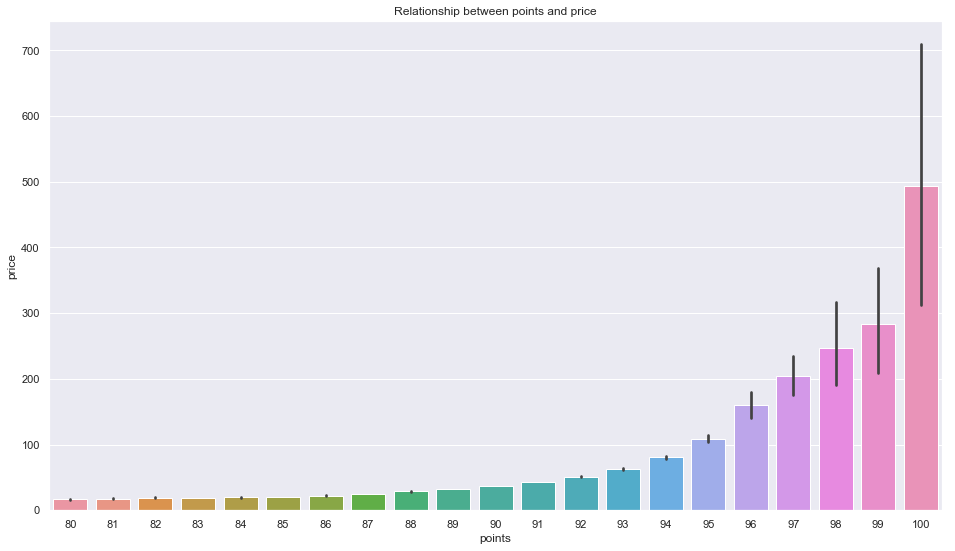

In [1187]:
sb.set(rc={'figure.figsize':(16,9)})
ax = sb.barplot(x="points", y="price", data=df);
ax.set_title('Relationship between points and price');

## What is the most overpriced and underpriced wines in the dataset?

In [1188]:
# We'll first calculate the average price for each point value
m = {}
for p in range(80,101):
    m[p] = df[df.points == p].price.mean()
print(m)

{80: 16.465753424657535, 81: 17.513385826771653, 82: 19.09358128374325, 83: 18.388378080176537, 84: 19.436706689536877, 85: 20.026690182245737, 86: 22.231200498353655, 87: 24.81974703662009, 88: 28.554301284546515, 89: 32.028255303584494, 90: 36.863200114596765, 91: 43.099593102111996, 92: 50.844102092435044, 93: 62.77553118574366, 94: 81.00146972369194, 95: 109.06164874551972, 96: 159.5481171548117, 97: 203.7029702970297, 98: 246.3134328358209, 99: 283.6296296296296, 100: 493.5}


In [1189]:
# Create a new column to store the price difference for each wine based on its points
df['price_diff'] = df.apply(lambda row: row['price'] / m[row['points']], axis=1)


### The most overpriced wine in the dataset

In [1190]:
overpriced = df[df.price_diff == df.price_diff.max()]
overpriced

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,price_diff
80290,80290,France,This ripe wine shows plenty of blackberry frui...,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,2013.0,115.569279


In [1191]:
overpriced.price_diff * 100

80290    11556.927859
Name: price_diff, dtype: float64

In [1193]:
underpriced = df[df.price_diff == df.price_diff.min()]
underpriced

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year,price_diff
101580,101580,US,"Superb fruit highlights this tight, sculpted S...",NaN,96,20.0,Washington,Columbia Valley (WA),Columbia Valley,Paul Gregutt,@paulgwine,Rulo 2007 Syrah (Columbia Valley (WA)),Syrah,Rulo,2007.0,0.125354


In [1194]:
underpriced.price_diff * 100

101580    12.535403
Name: price_diff, dtype: float64

# Model the data

### In this final step we'll attempt to predcit the wine rating based on a subset of other features. 

This requires some further cleaning of the data to produce a less sparse dataset.

In [1207]:
# Remove wines from countries with less than 5000 entries
df = df.groupby('country').filter(lambda x: len(x) > 5000)

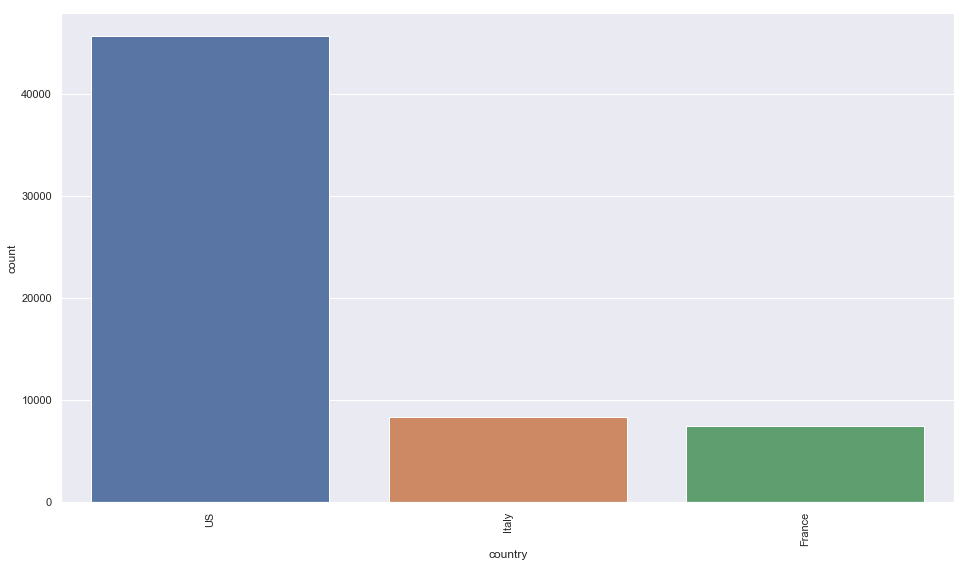

In [1208]:
plot_values(df, 'country')

In [1209]:
# Remove wines from provinces with less than 200 entries!
df = df.groupby('province').filter(lambda x: len(x) > 200)

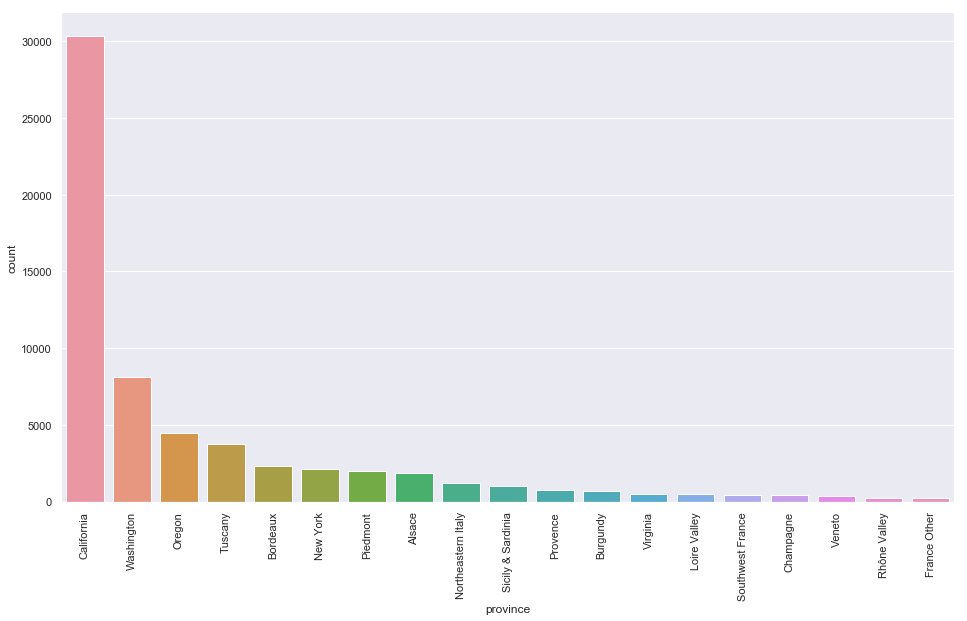

In [1210]:
plot_values(df, 'province')

In [1211]:
df.shape

(61395, 16)

In [1212]:
# Remove wines from regions with less than 100 entries!
df = df.groupby('region_1').filter(lambda x: len(x) > 200)

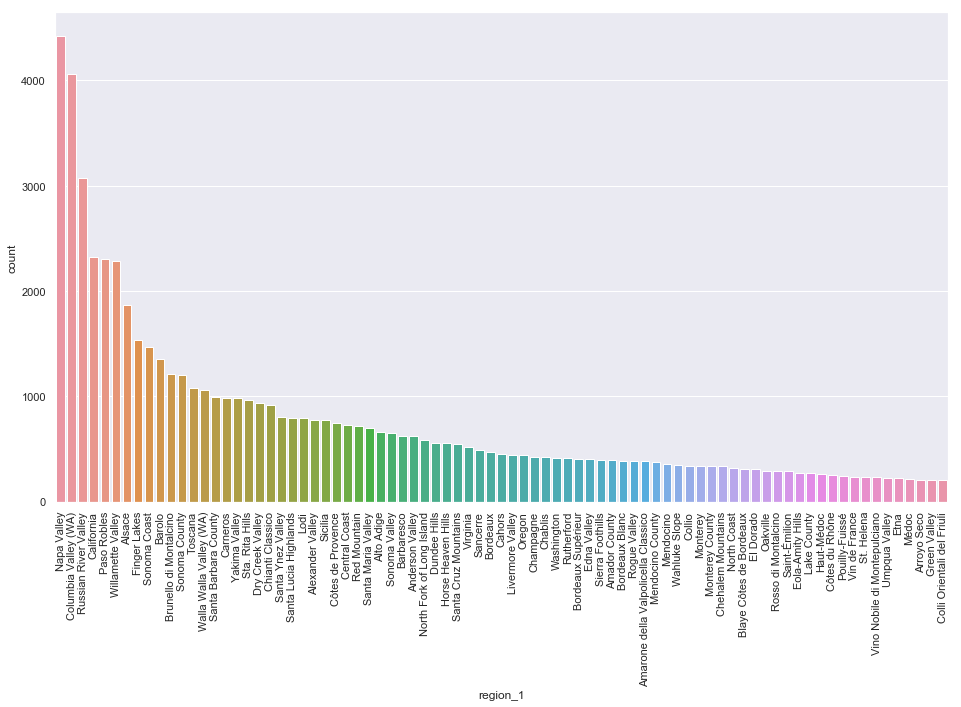

In [1213]:
plot_values(df, 'region_1')

In [1214]:
df.shape

(61395, 16)

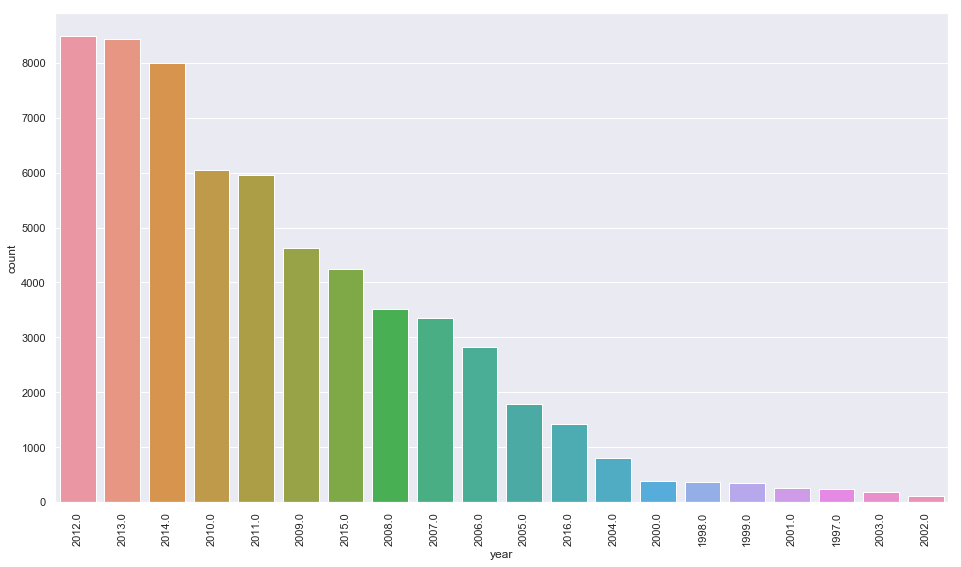

In [1215]:
plot_values(df, 'year')

In [1216]:
# Remove wines older than 1997
df = df[df.year >= 1997]

In [1217]:
df.shape

(61395, 16)

## The points seem to be normally distributed

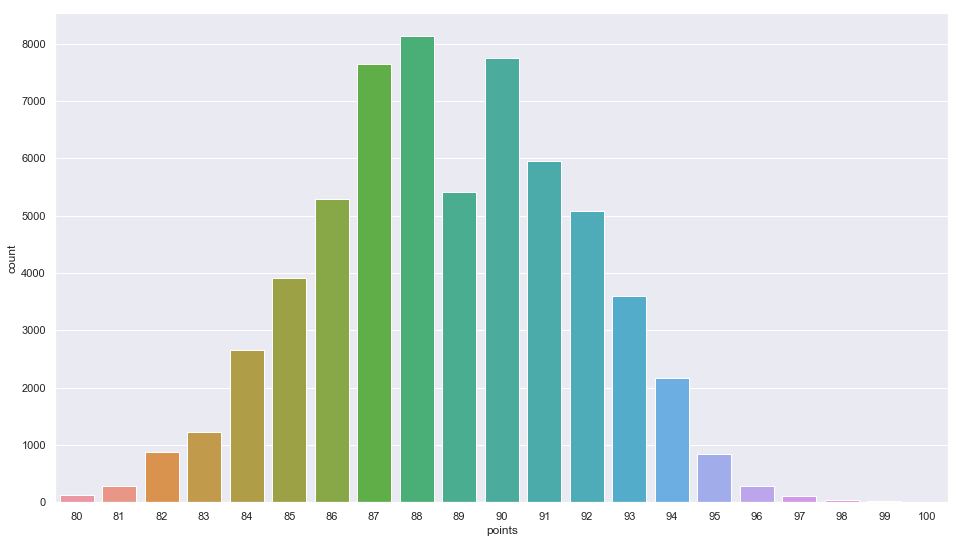

In [1218]:
sb.countplot(df.points);

## Instead of creating a regression model and try to predict the actual points, we'll group the wines into five categories and treat this as a classification problem

80-82 points: Poor wines

83-86 points: Below average wines

87-91 points: Average wines

92-95 points: Above average wines

96-100 points: Excellent wines

In [1219]:
def point_group(p):
    '''
    INPUT
    p - number of points 
    
    OUTPUT
    an int in the range 0-4 designating the group
    
    '''    
    if p < 83:
        return 0
    elif p < 87:
        return 1
    elif p < 92:
        return 2
    elif p < 96:
        return 3
    else:
        return 4    

In [1220]:
def clean(df):
    '''
    INPUT
    df - a DataFrame
    
    OUTPUT
    X - A DataFrame containing the features we'll use in our models
    y - A DataFrame containing the target categories 
    
    '''
    # Initialize X with teh subset of features we care about
    X = df[['country', 'points', 'province', 'region_1', 'variety', 'year', 'price']]
    
    # Drop all NaNs (turns out we don't lose too much data this way and it simplifies things)
    X = X.dropna()
    
    # One-hot encode categorical variables
    for c in ['country', 'province', 'variety', 'region_1']:
        X = pd.concat([X, pd.get_dummies(X[c], prefix=c)], axis = 1)
        
    # Create the 'y' DataFrame by assigning a group value based on the number of points
    y = X['points'].apply(lambda x : point_group(x))
    
    # Remove the points as well as the now one-hot encoded features from X
    X = X.drop('points', axis=1)
    X = X.drop(['country', 'province', 'variety', 'region_1'], axis=1)
    
    # Normalize numerical values 
    X.year = (X.year - 1997) / 20
    X.price = X['price'].apply(lambda x: np.log(x + 1))
    
    print("X.shape: " + str(X.shape))
    print("y.shape: " + str(y.shape))
    
    return X,y

In [1221]:
X, y = clean(df)

X.shape: (61395, 377)
y.shape: (61395,)


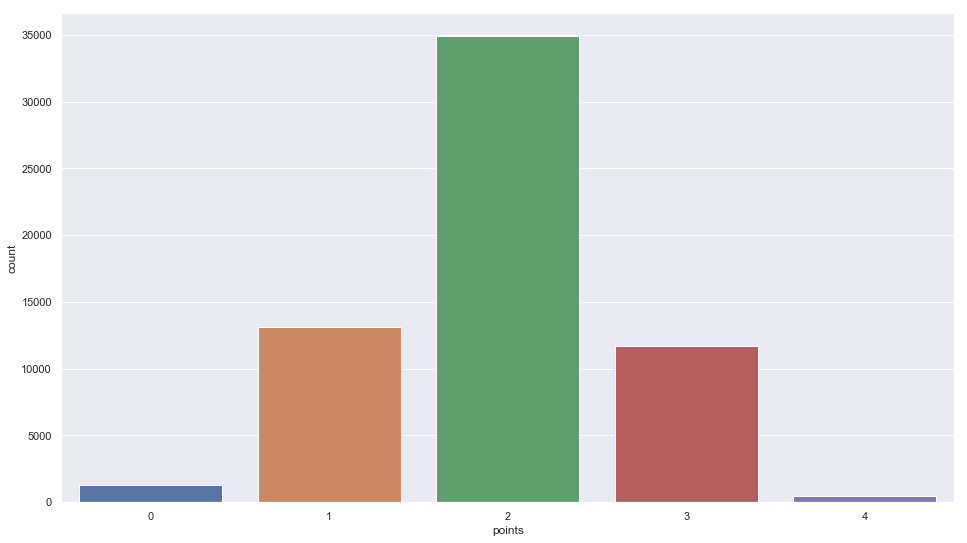

In [1222]:
# Take a look at the distribution of y values
sb.countplot(y);

In [1223]:
# Split X and y into training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42) 


In [1224]:
def fit_train_predict(model):
    '''
    INPUT
    model - An initialized Scikit Learn classifier model
    
    OUTPUT
    None
    
    '''
    
    # Fit the model with the training data
    model.fit(X_train, y_train)
    
    # Predict y for both training and test data
    y_test_preds = model.predict(X_test)
    y_train_preds = model.predict(X_train)
    
    # Calculate the accuracy score for training and test data predictions
    acc_train = accuracy_score(y_train, y_train_preds)
    acc_test = accuracy_score(y_test, y_test_preds)
    
    print ("Training data accuracy: " + str(acc_train))
    print ("Test data accuracy: " + str(acc_test))
    

## Random Forest Classifier with default values

In [830]:
rfc = RandomForestClassifier()
fit_train_predict(rfc)

Training data accuracy: 0.8665557792757302
Test data accuracy: 0.5332224459423969


## Multi-layer Perceptron Classifier (Neural Network): Two hidden layers with 64 and 16 nodes

In [831]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(64, 16), random_state=1)

fit_train_predict(nn)

Training data accuracy: 0.5665470250080248
Test data accuracy: 0.5669263766085967


## Multi-layer Perceptron Classifier (Neural Network): Two hidden layers with 32 and 16 nodes

In [832]:
nn = MLPClassifier(solver='adam', alpha=1e-5, activation='relu',
                     hidden_layer_sizes=(32, 16), random_state=1)

fit_train_predict(nn)

Training data accuracy: 0.5845224546966646
Test data accuracy: 0.5621990720476232


## Attempt to improve the neural network model using Grid Search to optimize the parameters

In [795]:
param_grid = { 
    'solver': ['lbfgs', 'adam', 'sgd'],
#    'hidden_layer_sizes': [(64,16), (32,16), (64,8), (32,8)],
    'hidden_layer_sizes': [(32,16), (32,8)],
    'activation' : ['relu', 'tanh', 'logistic'],
    'alpha' :[1e-5, 1e-4, 1e-3]
}


gscv = GridSearchCV(nn, param_grid=param_grid, verbose=3)

#scorer = make_scorer(fbeta_score, beta = 0.5, average='weighted')

grid_fit = gscv.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (nn.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=lbfgs, score=0.5753172588832487, total=  13.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=lbfgs 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=lbfgs, score=0.5762421473443746, total=  16.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=lbfgs 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.4s remaining:    0.0s


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=lbfgs, score=0.5664424419342556, total=  16.5s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam, score=0.5774111675126904, total=  19.7s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam, score=0.5695158322228567, total=  24.0s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam, score=0.5682827770021577, total=  29.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd 


C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5751903553299492, total=  47.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5755441335110096, total=  46.8s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5611118162203326, total=  40.1s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=lbfgs, score=0.5658629441624365, total=  14.3s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=lbfgs, score=0.5693889206167904, total=  14.9s
[CV] activation=relu, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=1

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), solver=sgd, score=0.575, total=  49.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5761786915413415, total=  48.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5614925751998985, total=  37.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=lbfgs, score=0.561992385786802, total=  14.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=lbfgs, score=0.5691350974046576, total=  14.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=0.000

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5751269035532995, total=  47.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5759248683292088, total=  46.9s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 16), solver=sgd, score=0.5615560350298261, total=  37.5s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 8), solver=lbfgs, score=0.5691624365482234, total=  15.2s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=0.001, hidden_layer_sizes=(32, 8), solver=lbfgs, score=0.56957928802589, total=  14.6s
[CV] activation=relu, alpha=0.001, hidden_layer_sizes=(32, 8), solver=lbfgs 
[CV]  activation=relu, alpha=0.0

[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=adam, score=0.5743384732533791, total=  32.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=adam 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=adam, score=0.5695519736007107, total=  51.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=sgd, score=0.5682741116751269, total=  42.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=sgd, score=0.5671679675106288, total=  43.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=sgd 
[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(32, 8), solver=sgd, score=0.5598426196217794, total=  36.5s
[CV] activation=tanh, alpha=0.001, hidden_layer_sizes=(32, 16), solver=lbfgs 
[CV]  activation=tanh, alpha=0

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam, score=0.5780456852791879, total=  53.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam, score=0.5797322165112, total=  37.0s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=adam, score=0.5692981342810002, total=  45.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd, score=0.44289340101522845, total=   4.8s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), solver=sgd, score=0.44292150517164797, total=   4.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 16), sol

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=adam, score=0.5775747192080716, total=  53.7s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=adam 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=adam, score=0.5709480898591192, total=  37.3s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=sgd 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=sgd, score=0.44289340101522845, total=   6.9s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=sgd 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=sgd, score=0.44292150517164797, total=   6.5s
[CV] activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=sgd 
[CV]  activation=logistic, alpha=1e-05, hidden_layer_sizes=(32, 8), solver=sgd, score=0.4428861530651098, total=   6.2s
[CV] activation=logistic, alpha=0.0001, hidden_layer_sizes=(32, 16), solver=lbf

[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 73.5min finished


Unoptimized model
------
Accuracy score on testing data: 0.5795

Optimized Model
------
Final accuracy score on the testing data: 0.5747


In [796]:
best_clf.get_params

<bound method BaseEstimator.get_params of MLPClassifier(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(32, 16), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)>

## Attempt to improve the Random Forest model using Grid Search to optimize the parameters

In [797]:
param_grid = { 
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth' : [4,6,8,10],
    'max_features' :['auto', 0.5, None]
}


gscv = GridSearchCV(rfc, param_grid=param_grid, verbose=3)

#scorer = make_scorer(fbeta_score, beta = 0.5, average='weighted')

grid_fit = gscv.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (rfc.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.4471446700507614, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.4599911161875754, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.4519609087447646, total=   0.2s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, score=0.46034263959390864, total=   1.3s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, score=0.45859508852084524, total=   1.1s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, score=0.461099124254347, total=   1.2s
[CV] criterion=gini, max_depth=4, max_features=0.5, n_estimators=10 ..
[CV]  criterion=gini, max_depth=4, max_features=0.5, n_estimators=10, score=0.5471446700507614, total=   0.8s
[CV] criterion=gini, max_depth=4, max_features=0.5, n_estimators=10 ..
[CV]  criterion=gini, max_depth=4, max_features=0.5, n_estimators=10, score=0.546544831

[CV]  criterion=gini, max_depth=8, max_features=0.5, n_estimators=100, score=0.5660616829546897, total=  15.2s
[CV] criterion=gini, max_depth=8, max_features=None, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=None, n_estimators=10, score=0.5715101522842639, total=   2.6s
[CV] criterion=gini, max_depth=8, max_features=None, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=None, n_estimators=10, score=0.5679294371470271, total=   2.6s
[CV] criterion=gini, max_depth=8, max_features=None, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=None, n_estimators=10, score=0.565807843634979, total=   2.6s
[CV] criterion=gini, max_depth=8, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=8, max_features=None, n_estimators=100, score=0.5714467005076143, total=  25.4s
[CV] criterion=gini, max_depth=8, max_features=None, n_estimators=100 
[CV]  criterion=gini, max_depth=8, max_features=None, n_estimators=100, score=0.5717367853

[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=10, score=0.4534839446630283, total=   0.2s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=100, score=0.4805203045685279, total=   1.6s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=100, score=0.4733802906275779, total=   1.6s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=100, score=0.47753522020560984, total=   1.6s
[CV] criterion=entropy, max_depth=6, max_features=0.5, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=0.5, n_estimators=10, score=0.5563451776649746, total=   1.1s
[CV] criterion=entropy, max_depth=6, max_features=0.5, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=0.5, n_est

[CV]  criterion=entropy, max_depth=10, max_features=0.5, n_estimators=100, score=0.5725617107684497, total=  16.1s
[CV] criterion=entropy, max_depth=10, max_features=0.5, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, max_features=0.5, n_estimators=100, score=0.5692981342810002, total=  15.7s
[CV] criterion=entropy, max_depth=10, max_features=None, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=None, n_estimators=10, score=0.5729695431472082, total=   2.9s
[CV] criterion=entropy, max_depth=10, max_features=None, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=None, n_estimators=10, score=0.5678659813439939, total=   2.9s
[CV] criterion=entropy, max_depth=10, max_features=None, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=None, n_estimators=10, score=0.5675847188729535, total=   2.8s
[CV] criterion=entropy, max_depth=10, max_features=None, n_estimators=100 
[CV]  criterion=entropy, max_depth=10, max_features=No

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 16.7min finished


Unoptimized model
------
Accuracy score on testing data: 0.5511

Optimized Model
------
Final accuracy score on the testing data: 0.5775
